# Introduction to Xoak

This notebook briefly shows how to use Xoak with Xarray's [advanced indexing](http://xarray.pydata.org/en/stable/indexing.html#more-advanced-indexing) to perform point-wise selection of irrelgularly spaced data encoded in coordinates with an arbitrary number of dimensions (1, 2, ..., n-d).

In [1]:
import numpy as np
import xarray as xr
import xoak

xr.set_options(display_style='text');

Let's first create an `xarray.Dataset` of latitude / longitude points located randomly on the sphere, forming a 2-dimensional (x, y) model mesh (note that Xoak supports indexing coordinates with an arbitrary number of dimensions).

In [2]:
shape = (100, 100)
lat = np.random.uniform(-90, 90, size=shape)
lon = np.random.uniform(-180, 180, size=shape)

field = lat + lon

In [3]:
ds_mesh = xr.Dataset(
    coords={'lat': (('x', 'y'), lat), 'lon': (('x', 'y'), lon)},
    data_vars={'field': (('x', 'y'), field)},
)

ds_mesh

<xarray.Dataset>
Dimensions:  (x: 100, y: 100)
Coordinates:
    lat      (x, y) float64 -46.35 76.28 -85.01 -13.43 ... 62.3 -88.36 5.12
    lon      (x, y) float64 -1.377 53.78 52.71 -174.7 ... -164.6 -116.2 -51.76
Dimensions without coordinates: x, y
Data variables:
    field    (x, y) float64 -47.72 130.1 -32.3 -188.1 ... -102.3 -204.5 -46.64

We first need to build an index to allow fast point-wise selection. Xoak supports several indexes that can be used depending on the data. Here we use the `sklearn_geo_balltree` index, a wrapper around [sklearn.BallTree](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.BallTree.html#sklearn.neighbors.BallTree) using the Haversine distance metric that is suited for indexing latitude / longitude points.

With this index, it is important to specify `lat` and `lon` in this specific order. Both the `lat` and `lon` coordinates must have exactly the same dimensions in the same order, here `('x', 'y')`.

In [4]:
ds_mesh.xoak.set_index(['lat', 'lon'], 'sklearn_geo_balltree')

Let's create another `xarray.Dataset` of latitude / longitude points that here correspond to a trajectory on the sphere.

In [5]:
ds_trajectory = xr.Dataset({
    'latitude': ('trajectory', np.linspace(-10, 40, 30)),
    'longitude': ('trajectory', np.linspace(-150, 150, 30))
})

ds_trajectory

<xarray.Dataset>
Dimensions:    (trajectory: 30)
Dimensions without coordinates: trajectory
Data variables:
    latitude   (trajectory) float64 -10.0 -8.276 -6.552 ... 36.55 38.28 40.0
    longitude  (trajectory) float64 -150.0 -139.7 -129.3 ... 129.3 139.7 150.0

We can use `xarray.Dataset.xoak.sel()` to select the mesh points that are the closest to the trajectory vertices. It works very much like `xarray.Dataset.sel()` and returns another Dataset with the selection.

Like for `xarray.Dataset.xoak.set_index()`, it is important here that all indexer coordinates (`latitude` and `longitude` in this example) have the exact same dimensions (here `'trajectory'`). Indexers must be given for each coordinate used to build the index above, (here `latitude` for `lat` and `longitude` for `lon`). 

In [6]:
ds_selection = ds_mesh.xoak.sel(
    lat=ds_trajectory.latitude,
    lon=ds_trajectory.longitude
)

ds_selection

<xarray.Dataset>
Dimensions:  (trajectory: 30)
Coordinates:
    lat      (trajectory) float64 -11.46 -8.57 -6.349 ... 37.13 38.05 41.56
    lon      (trajectory) float64 -150.6 -139.7 -129.9 ... 129.0 140.2 149.2
Dimensions without coordinates: trajectory
Data variables:
    field    (trajectory) float64 -162.1 -148.3 -136.3 ... 166.2 178.2 190.8

Let's plot the trajectory vertices (black dots) and the resulting selection (dots colored by the `field` values):

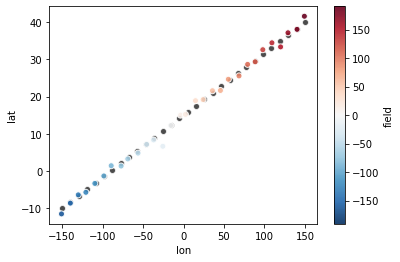

In [7]:
ds_trajectory.plot.scatter(x='longitude', y='latitude', c='k', alpha=0.7);
ds_selection.plot.scatter(x='lon', y='lat', hue='field', alpha=0.9);

You can also return the distances associated with each selected point by inputting the name of the distance variable you would like used as the variable named in the returned Dataset. Note that if a DataArray was originally input, a Dataset will still be returned in this case. Distances are returned in kilometers.

In [8]:
ds_selection = ds_mesh.xoak.sel(
    lat=ds_trajectory.latitude,
    lon=ds_trajectory.longitude,
    distances_name="distance",
)

ds_selection

<xarray.Dataset>
Dimensions:   (trajectory: 30)
Coordinates:
    lat       (trajectory) float64 -11.46 -8.57 -6.349 ... 37.13 38.05 41.56
    lon       (trajectory) float64 -150.6 -139.7 -129.9 ... 129.0 140.2 149.2
Dimensions without coordinates: trajectory
Data variables:
    field     (trajectory) float64 -162.1 -148.3 -136.3 ... 166.2 178.2 190.8
    distance  (trajectory) float64 176.9 33.55 71.99 198.1 ... 69.07 52.98 185.2

Xoak also supports providing coordinates with an arbitrary number of dimensions as indexers, like in the example below with vertices of another mesh on the sphere. 

In [9]:
ds_mesh2 = xr.Dataset({
    'latitude': (('x', 'y'), np.random.uniform(-90, 90, size=(10, 10))),
    'longitude': (('x', 'y'), np.random.uniform(-180, 180, size=(10, 10)))
})

ds_selection = ds_mesh.xoak.sel(
    lat=ds_mesh2.latitude,
    lon=ds_mesh2.longitude
)

ds_selection

<xarray.Dataset>
Dimensions:  (x: 10, y: 10)
Coordinates:
    lat      (x, y) float64 -26.81 52.21 54.89 81.46 ... -14.37 -6.231 56.52
    lon      (x, y) float64 -7.988 96.58 57.14 -122.8 ... 47.32 -177.5 -79.93
Dimensions without coordinates: x, y
Data variables:
    field    (x, y) float64 -34.79 148.8 112.0 -41.3 ... 32.96 -183.7 -23.41

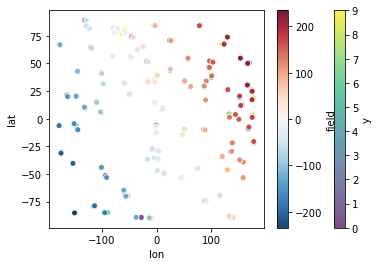

In [10]:
ds_mesh2.plot.scatter(x='longitude', y='latitude', c='k', alpha=0.7);
ds_selection.plot.scatter(x='lon', y='lat', hue='field', alpha=0.9);